In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
import numpy as np

In [2]:
house_data = pd.read_csv('kc_house_data.csv')

Our dataset is only 2.5 MBs, so we skip the subsampling step here.

In [3]:
house_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


In [4]:
house_data['sqft_basement'].value_counts().head()

0.0      12826
?          454
600.0      217
500.0      209
700.0      208
Name: sqft_basement, dtype: int64

454 of our entries list basement size as '?'. Since we don't know whether or not these houses even have basements, and we have 21,597 entries anyway, we choose to drop these.

In [72]:
basement_data = house_data[house_data.sqft_basement == '?']

,sqft_living,sqft_above
6,1715,1715
18,1200,1200
42,3595,3595
79,3450,3450
112,1540,1160
115,4380,2780
217,2250,2250
309,3320,2220
384,4800,3480
508,1540,820


In [74]:
basement_data['sqft_basement'] = basement_data['sqft_living'] - basement_data['sqft_above']

In [76]:
basement_data['sqft_basement'].head(10)

6         0
18        0
42        0
79        0
112     380
115    1600
217       0
309    1100
384    1320
508     720
Name: sqft_basement, dtype: int64

In [6]:
house_data = house_data[house_data.sqft_basement != '?']
house_data['sqft_basement'] = house_data['sqft_basement'].astype(float)
house_data['sqft_basement'].value_counts().head()

0.0      12826
600.0      217
500.0      209
700.0      208
800.0      201
Name: sqft_basement, dtype: int64

In [7]:
house_data['view'].isna().sum()

61

We have 61 NaN values for view. Since this is still not a large proportion of our observations, we choose to discard the afflicted rows. 

In [8]:
house_data = house_data.dropna(subset=['view'])
house_data['view'].isna().sum()

0

In [9]:
house_data['yr_renovated'].value_counts().head()

0.0       16618
2014.0       69
2003.0       31
2013.0       31
2007.0       30
Name: yr_renovated, dtype: int64

Since so many values here are 0 and we don't want to make any unsafe assumptions, we elect to drop this column entirely.

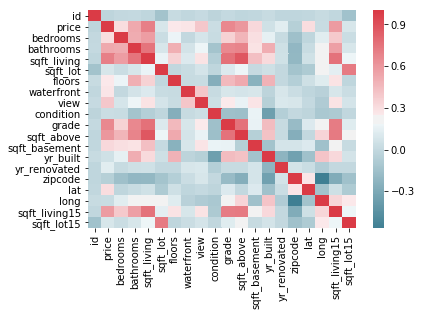

In [10]:
color_map = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(house_data.corr(), cmap=color_map)

In [11]:
house_data.corr()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,1.000000,-0.016413,0.002267,0.005873,-0.011866,-0.132412,0.019150,-0.004114,0.012859,-0.023410,0.008765,-0.010757,-0.004480,0.022179,-0.010372,-0.010959,-0.005062,0.021254,-0.003084,-0.138114
price,-0.016413,1.000000,0.308454,0.525029,0.702004,0.088400,0.256603,0.272661,0.397176,0.034613,0.668099,0.605481,0.323018,0.054849,0.128517,-0.053429,0.307667,0.022512,0.586495,0.083530
bedrooms,0.002267,0.308454,1.000000,0.513694,0.577696,0.032531,0.178518,-0.001839,0.080379,0.025652,0.356418,0.478967,0.301987,0.156820,0.018979,-0.152539,-0.009939,0.131398,0.391936,0.030779
bathrooms,0.005873,0.525029,0.513694,1.000000,0.754793,0.088451,0.503796,0.065559,0.187249,-0.128167,0.665992,0.685959,0.281813,0.508866,0.051479,-0.204016,0.025243,0.224660,0.569396,0.089414
sqft_living,-0.011866,0.702004,0.577696,0.754793,1.000000,0.173266,0.354260,0.108855,0.283797,-0.061626,0.762719,0.876787,0.433369,0.319584,0.054105,-0.198987,0.053213,0.241473,0.756199,0.184920
sqft_lot,-0.132412,0.088400,0.032531,0.088451,0.173266,1.000000,-0.007745,0.022598,0.072668,-0.009207,0.113801,0.183653,0.015612,0.052469,0.003641,-0.129626,-0.085076,0.230489,0.143815,0.719499
floors,0.019150,0.256603,0.178518,0.503796,0.354260,-0.007745,1.000000,0.020870,0.027748,-0.264259,0.459144,0.523594,-0.245628,0.489898,0.002684,-0.058443,0.049237,0.125360,0.279379,-0.011632
waterfront,-0.004114,0.272661,-0.001839,0.065559,0.108855,0.022598,0.020870,1.000000,0.404847,0.017261,0.086431,0.073915,0.087926,-0.025964,0.083825,0.030884,-0.012267,-0.038770,0.088693,0.031551
view,0.012859,0.397176,0.080379,0.187249,0.283797,0.072668,0.027748,0.404847,1.000000,0.045464,0.250014,0.166907,0.276521,-0.054415,0.098948,0.085300,0.006174,-0.076306,0.280934,0.072797
condition,-0.023410,0.034613,0.025652,-0.128167,-0.061626,-0.009207,-0.264259,0.017261,0.045464,1.000000,-0.148886,-0.159186,0.170361,-0.361838,-0.062166,0.002616,-0.016021,-0.105805,-0.093556,-0.004386


Zipcode and longitude have a strong negative correlation with each other, and we expect latitude/longitude to be far more useful predictors than zipcode. So we choose to drop zipcode as well.

We drop sqft_above and sqft_living15 in favor of sqft_living as well, due to their high multicollinearity. 

We dropped grade because the documentation of the column showed that part of the grading system includes square footage as well as number of bathrooms.

In [12]:
house_data = house_data.drop('yr_renovated', axis=1)
house_data = house_data.drop('zipcode', axis=1)
house_data = house_data.drop('sqft_above', axis=1)
house_data = house_data.drop('sqft_living15', axis=1)
house_data = house_data.drop('grade', axis=1)
#Bathrooms and bedrooms have high correlation with sqft_living.
#However, we choose not to remove them yet. Maybe experiment with that?
house_data.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition',
       'sqft_basement', 'yr_built', 'lat', 'long', 'sqft_lot15'],
      dtype='object')

In [13]:
house_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21082 entries, 0 to 21596
Data columns (total 16 columns):
id               21082 non-null int64
date             21082 non-null object
price            21082 non-null float64
bedrooms         21082 non-null int64
bathrooms        21082 non-null float64
sqft_living      21082 non-null int64
sqft_lot         21082 non-null int64
floors           21082 non-null float64
waterfront       18749 non-null float64
view             21082 non-null float64
condition        21082 non-null int64
sqft_basement    21082 non-null float64
yr_built         21082 non-null int64
lat              21082 non-null float64
long             21082 non-null float64
sqft_lot15       21082 non-null int64
dtypes: float64(8), int64(7), object(1)
memory usage: 2.7+ MB


In [14]:
# Waterfront has null values, since the number of nulls is a little high, fill with the highest categorical which is 0
house_data = house_data.fillna(0)

In [15]:
house_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21082 entries, 0 to 21596
Data columns (total 16 columns):
id               21082 non-null int64
date             21082 non-null object
price            21082 non-null float64
bedrooms         21082 non-null int64
bathrooms        21082 non-null float64
sqft_living      21082 non-null int64
sqft_lot         21082 non-null int64
floors           21082 non-null float64
waterfront       21082 non-null float64
view             21082 non-null float64
condition        21082 non-null int64
sqft_basement    21082 non-null float64
yr_built         21082 non-null int64
lat              21082 non-null float64
long             21082 non-null float64
sqft_lot15       21082 non-null int64
dtypes: float64(8), int64(7), object(1)
memory usage: 2.7+ MB


Okay, we just scrubbed a lot of data--how do the remaining columns correlate with each other?

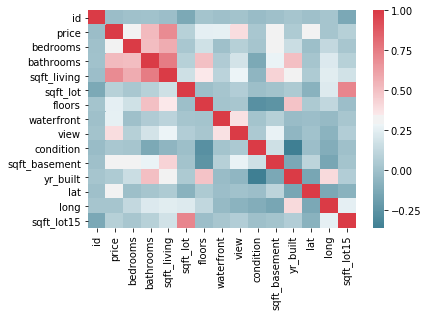

In [16]:
color_map = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(house_data.corr(), cmap=color_map)

In [17]:
# we want to target our model to the majority of users, 
# but perhaps not to the people that are buying mansions/celebrities in the area
price_90th_perc = np.percentile(house_data['price'], 90)

house_data = house_data.drop(house_data[house_data['price'] > price_90th_perc].index)
house_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18973 entries, 0 to 21596
Data columns (total 16 columns):
id               18973 non-null int64
date             18973 non-null object
price            18973 non-null float64
bedrooms         18973 non-null int64
bathrooms        18973 non-null float64
sqft_living      18973 non-null int64
sqft_lot         18973 non-null int64
floors           18973 non-null float64
waterfront       18973 non-null float64
view             18973 non-null float64
condition        18973 non-null int64
sqft_basement    18973 non-null float64
yr_built         18973 non-null int64
lat              18973 non-null float64
long             18973 non-null float64
sqft_lot15       18973 non-null int64
dtypes: float64(8), int64(7), object(1)
memory usage: 2.5+ MB


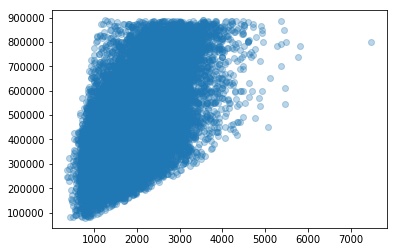

In [18]:
plt.scatter(house_data['sqft_living'], house_data['price'], alpha=0.3)

In [19]:
# remove strong outliers in sqft_living and bedrooms
house_data = house_data.drop(house_data[house_data['sqft_living'] > 12000].index)
house_data = house_data.drop(house_data[house_data['bedrooms']>30].index)

house_data.describe(), house_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18972 entries, 0 to 21596
Data columns (total 16 columns):
id               18972 non-null int64
date             18972 non-null object
price            18972 non-null float64
bedrooms         18972 non-null int64
bathrooms        18972 non-null float64
sqft_living      18972 non-null int64
sqft_lot         18972 non-null int64
floors           18972 non-null float64
waterfront       18972 non-null float64
view             18972 non-null float64
condition        18972 non-null int64
sqft_basement    18972 non-null float64
yr_built         18972 non-null int64
lat              18972 non-null float64
long             18972 non-null float64
sqft_lot15       18972 non-null int64
dtypes: float64(8), int64(7), object(1)
memory usage: 2.5+ MB


(                 id          price      bedrooms     bathrooms   sqft_living  \
 count  1.897200e+04   18972.000000  18972.000000  18972.000000  18972.000000   
 mean   4.618228e+09  450811.542536      3.298967      2.015048   1915.348777   
 std    2.878015e+09  177720.324784      0.874083      0.688757    721.316767   
 min    1.000102e+06   78000.000000      1.000000      0.500000    370.000000   
 25%    2.141460e+09  310000.000000      3.000000      1.500000   1370.000000   
 50%    3.928450e+09  425000.000000      3.000000      2.000000   1820.000000   
 75%    7.345851e+09  570000.000000      4.000000      2.500000   2360.000000   
 max    9.900000e+09  888990.000000     11.000000      7.500000   7480.000000   
 
            sqft_lot        floors    waterfront          view     condition  \
 count  1.897200e+04  18972.000000  18972.000000  18972.000000  18972.000000   
 mean   1.417976e+04      1.460811      0.002108      0.146743      3.404385   
 std    3.866768e+04      0.5

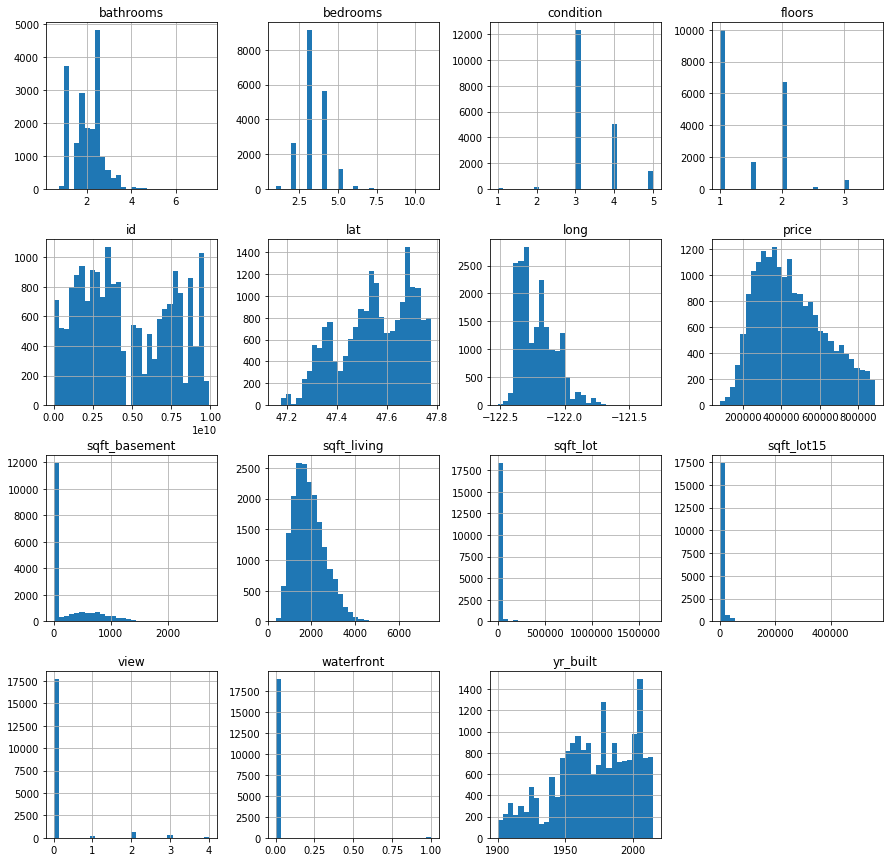

In [20]:
_ = house_data.hist(figsize=(15,15), bins=30)

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_basement,yr_built,lat,long,sqft_lot15
id,1.000000,0.026166,0.014795,0.034036,0.018382,-0.132483,0.034789,-0.004135,0.018101,-0.030927,-0.004442,0.030720,0.002515,0.023274,-0.143883
price,0.026166,1.000000,0.272130,0.414455,0.570978,0.088414,0.256794,0.037510,0.186186,0.031876,0.216195,0.058224,0.455809,0.084620,0.080854
bedrooms,0.014795,0.272130,1.000000,0.494994,0.606095,0.021883,0.150781,-0.034128,0.021384,0.021539,0.287467,0.170325,-0.049408,0.146159,0.019545
bathrooms,0.034036,0.414455,0.494994,1.000000,0.700541,0.051513,0.501755,-0.023111,0.063749,-0.140388,0.210469,0.561835,-0.031036,0.251223,0.052640
sqft_living,0.018382,0.570978,0.606095,0.700541,1.000000,0.146564,0.324928,-0.008122,0.133822,-0.075029,0.376609,0.359768,-0.021981,0.290951,0.162668
sqft_lot,-0.132483,0.088414,0.021883,0.051513,0.146564,1.000000,-0.025486,0.014197,0.091881,0.001504,0.008634,0.032999,-0.100208,0.219083,0.704609
floors,0.034789,0.256794,0.150781,0.501755,0.324928,-0.025486,1.000000,-0.014884,-0.021842,-0.280276,-0.307764,0.521651,0.024662,0.136732,-0.030885
waterfront,-0.004135,0.037510,-0.034128,-0.023111,-0.008122,0.014197,-0.014884,1.000000,0.276912,0.010379,0.018743,-0.038341,-0.040770,-0.054488,0.034768
view,0.018101,0.186186,0.021384,0.063749,0.133822,0.091881,-0.021842,0.276912,1.000000,0.026543,0.168950,-0.069350,-0.041406,-0.071770,0.088258
condition,-0.030927,0.031876,0.021539,-0.140388,-0.075029,0.001504,-0.280276,0.010379,0.026543,1.000000,0.170429,-0.348420,-0.020021,-0.093622,0.006215


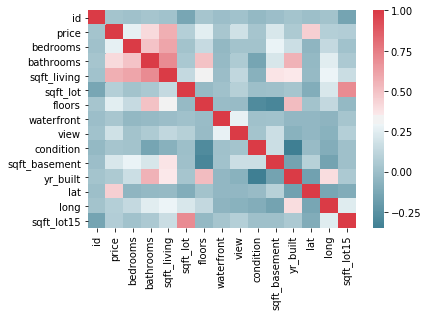

In [21]:
color_map = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(house_data.corr(), cmap=color_map)
house_data.corr()

In [22]:
# get a simple linear regression model for price and sqft_living
x = np.array(house_data['sqft_living'])
y = np.array(house_data['price'])

In [23]:
formula = 'y~x'
model = ols(formula=formula, data=house_data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.326
Model:                            OLS   Adj. R-squared:                  0.326
Method:                 Least Squares   F-statistic:                     9176.
Date:                Wed, 17 Apr 2019   Prob (F-statistic):               0.00
Time:                        12:57:27   Log-Likelihood:            -2.5251e+05
No. Observations:               18972   AIC:                         5.050e+05
Df Residuals:                   18970   BIC:                         5.050e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.814e+05   3005.720     60.339      0.000    1.75e+05    1.87e+05
x            140.6795      1.469     95.792      0.000     137.801     143.558
==============================================================================
Omnibus:                      618.096   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              601.420
Skew:                           0.397   Prob(JB):                    2.53e-131
Kurtosis:                       2.641   Cond. No.                     5.81e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.81e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [24]:
linreg = LinearRegression()
linreg.fit(x.reshape(-1,1), y.reshape(-1,1))

y_hat = linreg.predict(x.reshape(-1,1))

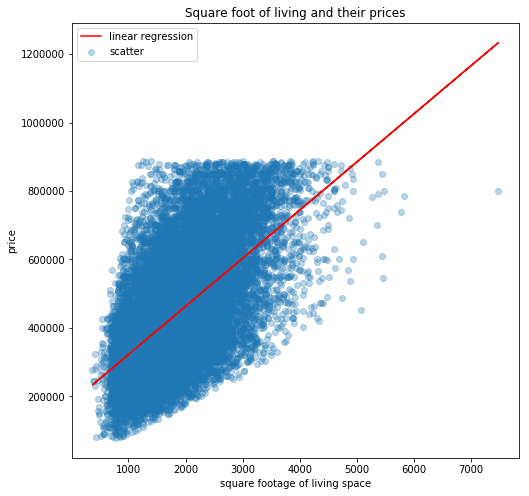

In [25]:
plt.figure(figsize=(8,8))
plt.scatter(x,y, label='scatter', alpha = 0.3)
plt.plot(x, y_hat, color='red', label='linear regression')
plt.title('Square foot of living and their prices')
plt.legend()
plt.xlabel('square footage of living space')
plt.ylabel('price')
plt.show()

In [26]:
from sklearn.metrics import mean_squared_error

sqft_living_mse = mean_squared_error(y, y_hat)
sqft_living_mse

21286324741.823715

In [27]:
from datetime import datetime

house_data['date'] = pd.to_datetime(house_data['date'])

In [28]:
house_data['date'].sort_values().head()

#dates are in a one year span so prices should not be too affected by 

2485    2014-05-02
8319    2014-05-02
14803   2014-05-02
19550   2014-05-02
19051   2014-05-02
Name: date, dtype: datetime64[ns]

What follows are our experiments with a preliminary multivariate model.

In [29]:
# preliminary multiple linear regression
outcome = 'price'
predictors = house_data.loc[:, ['sqft_living', 'yr_built', 'bedrooms', 'bathrooms', 'view']]
predictors_int = sm.add_constant(predictors)
model = sm.OLS(np.asarray(house_data['price']), np.asarray(predictors_int)).fit()

In [30]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.384
Model:                            OLS   Adj. R-squared:                  0.383
Method:                 Least Squares   F-statistic:                     2360.
Date:                Wed, 17 Apr 2019   Prob (F-statistic):               0.00
Time:                        12:57:29   Log-Likelihood:            -2.5166e+05
No. Observations:               18972   AIC:                         5.033e+05
Df Residuals:                   18966   BIC:                         5.034e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.027e+06   8.35e+04     36.228      0.000    2.86e+06    3.19e+06
x1           147.1483      2.190     67.184      0.000     142.855     151.441
x2         -1453.3737     43.164    -33.671      0.000   -1537.979   -1368.768
x3         -3.033e+04   1489.002    -20.367      0.000   -3.32e+04   -2.74e+04
x4          5.104e+04   2366.417     21.569      0.000    4.64e+04    5.57e+04
x5           2.44e+04   1767.289     13.808      0.000    2.09e+04    2.79e+04
==============================================================================
Omnibus:                      304.420   Durbin-Watson:                   1.956
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              309.190
Skew:                           0.297   Prob(JB):                     7.25e-68
Kurtosis:                       2.806   Cond. No.                     2.31e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.31e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [31]:
from sklearn.model_selection import train_test_split

In [32]:
X_train, X_test, y_train, y_test = train_test_split(predictors, house_data['price'], test_size=0.3)

In [33]:
# m_linreg = multiple linear regression (model)
m_linreg = LinearRegression()

In [34]:
m_linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [35]:
m_linreg.coef_

array([   148.94766686,  -1468.99245508, -31658.22395979,  52615.41601161,
        20649.240125  ])

In [36]:
m_linreg.intercept_

3056434.4200262055

In [37]:
y_hat_train = m_linreg.predict(X_train)
y_hat_test = m_linreg.predict(X_test)

In [38]:
from sklearn.metrics import mean_squared_error

train_rmse = np.sqrt(mean_squared_error(y_train, y_hat_train))
test_rmse = np.sqrt(mean_squared_error(y_test,y_hat_test))

print('train: ' + str(train_rmse) + 'test: ' + str(test_rmse))

train: 139831.2970977512test: 138897.33348100545


In [39]:
from sklearn.model_selection import cross_val_score

#rmse_scorer = make_scorer(rmse, greater_is_better=False) #TODO(Kayli) figure out rmse scorer
cv_5_results = cross_val_score(m_linreg, predictors, house_data['price'], cv=5, scoring='neg_mean_squared_error')

In [40]:
cv_5_results = np.sqrt(-1*cv_5_results)

In [41]:
cv_5_results

array([141839.07025927, 141015.49152172, 137592.16426884, 139552.35635951,
       140302.21308006])

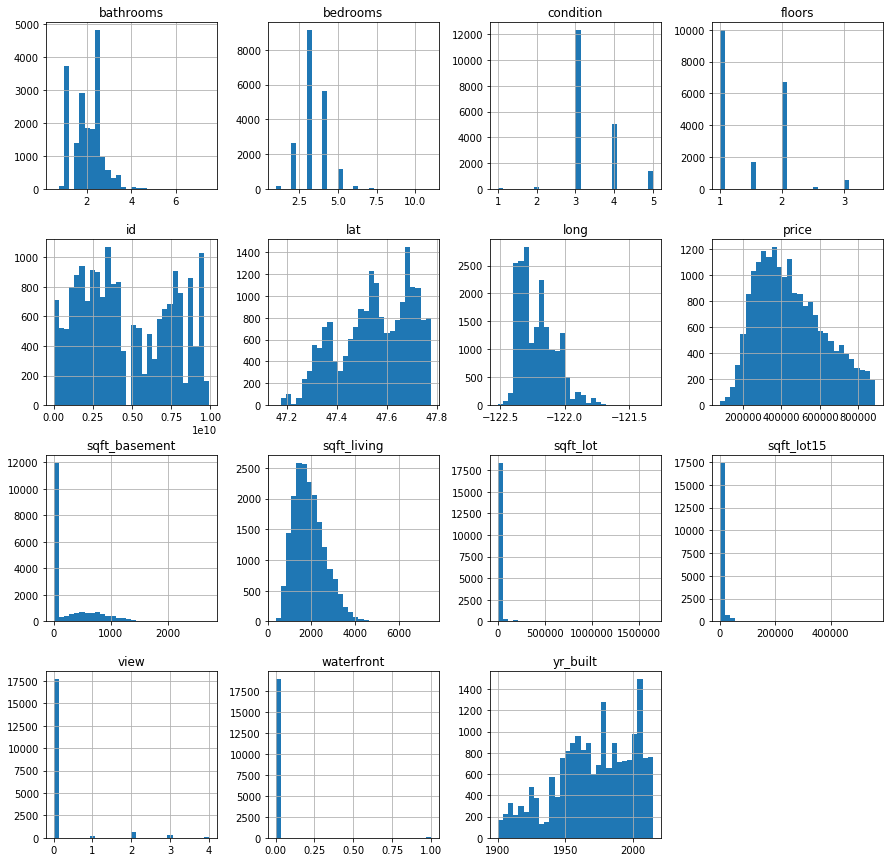

In [42]:
_ = house_data.hist(figsize=(15,15), bins=30)

Text(0.5, 1.0, 'bathrooms')

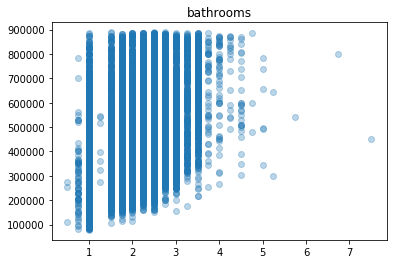

In [43]:
#TODO(Kayli) clean this so that it iterates through the df rather than writing out
plt.scatter(house_data['bathrooms'], house_data['price'], alpha = 0.3)
plt.title('bathrooms')

Text(0.5, 1.0, 'bedrooms')

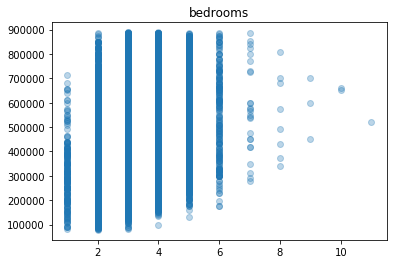

In [44]:
plt.scatter(house_data['bedrooms'], house_data['price'], alpha = 0.3)
plt.title('bedrooms')

Text(0.5, 1.0, 'condition')

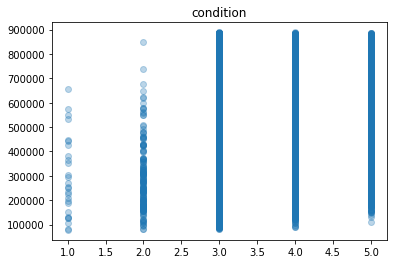

In [45]:
plt.scatter(house_data['condition'], house_data['price'], alpha = 0.3)
plt.title('condition')

Text(0.5, 1.0, 'floors')

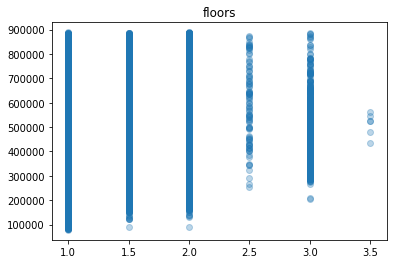

In [46]:
plt.scatter(house_data['floors'], house_data['price'], alpha = 0.3)
plt.title('floors')

Text(0.5, 1.0, 'id')

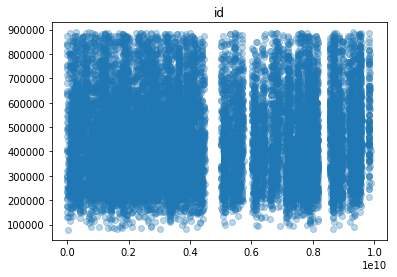

In [47]:
plt.scatter(house_data['id'], house_data['price'], alpha = 0.3)
plt.title('id')

Text(0.5, 1.0, 'lat')

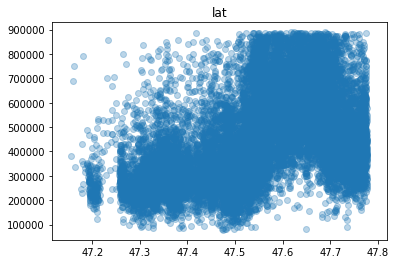

In [48]:
plt.scatter(house_data['lat'], house_data['price'], alpha = 0.3)
plt.title('lat')

Text(0.5, 1.0, 'long')

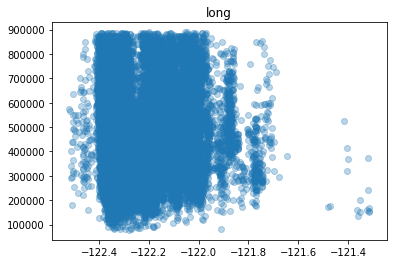

In [49]:
plt.scatter(house_data['long'], house_data['price'], alpha = 0.3)
plt.title('long')

Text(0.5, 1.0, 'sqft_basement')

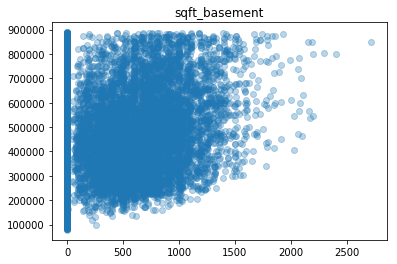

In [50]:
plt.scatter(house_data['sqft_basement'], house_data['price'], alpha = 0.3)
plt.title('sqft_basement')

Text(0.5, 1.0, 'sqft_living')

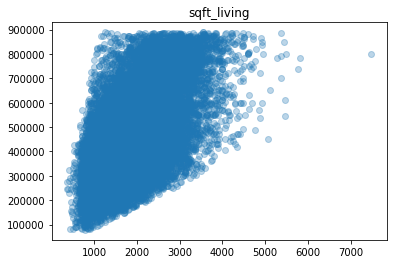

In [51]:
plt.scatter(house_data['sqft_living'], house_data['price'], alpha = 0.3)
plt.title('sqft_living')

Text(0.5, 1.0, 'sqft_lot')

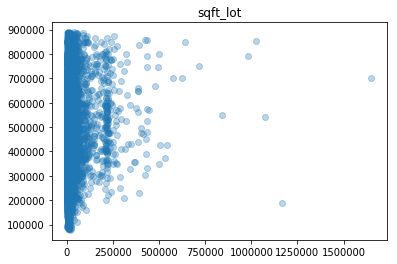

In [52]:
plt.scatter(house_data['sqft_lot'], house_data['price'], alpha = 0.3)
plt.title('sqft_lot')

Text(0.5, 1.0, 'sqft_lot15')

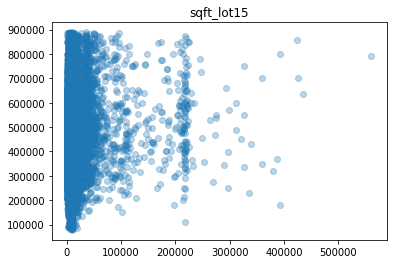

In [53]:
plt.scatter(house_data['sqft_lot15'], house_data['price'], alpha = 0.3)
plt.title('sqft_lot15')

Text(0.5, 1.0, 'view')

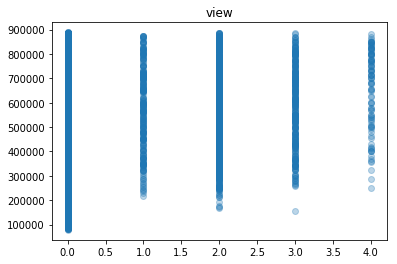

In [54]:
plt.scatter(house_data['view'], house_data['price'], alpha = 0.3)
plt.title('view')

Text(0.5, 1.0, 'waterfront')

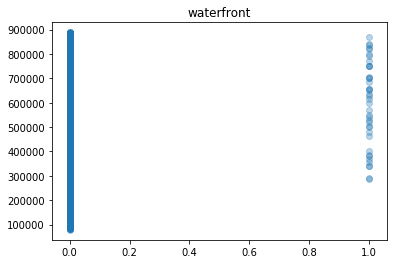

In [55]:
plt.scatter(house_data['waterfront'], house_data['price'], alpha = 0.3)
plt.title('waterfront')

Text(0.5, 1.0, 'yr_built')

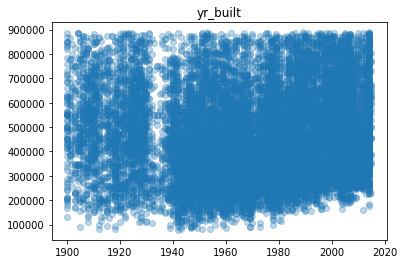

In [56]:
plt.scatter(house_data['yr_built'], house_data['price'], alpha = 0.3)
plt.title('yr_built')

In [57]:
# TODO(Kayli) price inflation to fit 2019. convert datetime to something else (days from first day in set?(2014-05-02))
# convert latitude and longitude to a distance from a certain point Seattle is 47.609795, -122.337173
# Create simple linear models for all variables

In [58]:
# A lot of the scatterplots have a slightly curved upward motion in relation to price. 
# The log of price, may improve the model.

log_y = np.log(house_data['price'])

Text(0.5, 1.0, 'Living Square Footage and log(Price)')

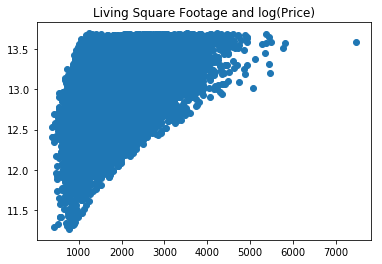

In [59]:
plt.scatter(house_data['sqft_living'], log_y)
plt.title('Living Square Footage and log(Price)')

In [60]:
log_formula = 'log_y~x'
log_model = ols(formula=log_formula, data=house_data).fit()
log_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  log_y   R-squared:                       0.312
Model:                            OLS   Adj. R-squared:                  0.312
Method:                 Least Squares   F-statistic:                     8599.
Date:                Wed, 17 Apr 2019   Prob (F-statistic):               0.00
Time:                        12:57:38   Log-Likelihood:                -6691.3
No. Observations:               18972   AIC:                         1.339e+04
Df Residuals:                   18970   BIC:                         1.340e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.3214      0.007   1737.105      0.000      12.308      12.335
x              0.0003   3.47e-06     92.728      0.000       0.000       0.000
==============================================================================
Omnibus:                      319.245   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              245.808
Skew:                          -0.193   Prob(JB):                     4.20e-54
Kurtosis:                       2.598   Cond. No.                     5.81e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.81e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Text(0.5, 1.0, 'Living Square Footage and log(Price)')

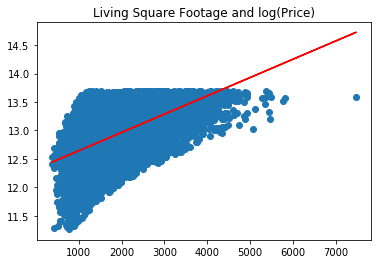

In [61]:
log_linreg = LinearRegression()
log_linreg.fit(x.reshape(-1,1), np.array(log_y).reshape(-1,1))
log_y_hat = log_linreg.predict(x.reshape(-1,1))
plt.scatter(house_data['sqft_living'], log_y)
plt.plot(x, log_y_hat, color='red')
plt.title('Living Square Footage and log(Price)')

In [62]:
sqft_living_mse_logged = mean_squared_error(log_y, log_y_hat)
sqft_living_mse_logged

0.11854192426263681

In [63]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error
from sklearn.linear_model import LinearRegression
from statistics import mean, median
from math import sqrt

In [64]:
def test_mean_err(X, y):
    """Train a model on the variables provided and return that model's RMSE."""
    linreg = LinearRegression()
    train_err, test_err = [], []
    for i in range(20):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
        linreg.fit(X_train, y_train)
        y_hat_train = linreg.predict(X_train)
        y_hat_test = linreg.predict(X_test)
        train_err.append(mean_absolute_error(y_train, y_hat_train))
        test_err.append(mean_absolute_error(y_test, y_hat_test))
        
    return mean(test_err)


def test_median_err(X, y):
    """Train a model on the variables provided and return that model's MAE."""
    linreg = LinearRegression()
    train_err, test_err = [], []
    for i in range(20):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
        linreg.fit(X_train, y_train)
        y_hat_train = linreg.predict(X_train)
        y_hat_test = linreg.predict(X_test)
        train_err.append(median_absolute_error(y_train, y_hat_train))
        test_err.append(median_absolute_error(y_test, y_hat_test))
        
    return mean(test_err)

In [65]:
X_1 = house_data[['sqft_living', 'bathrooms', 'bedrooms']]
X_2 = house_data[['lat', 'sqft_living']]
y = house_data['price']

In [66]:
test_mean_err(X_1, y), test_mean_err(X_2, y)

(119541.40960163831, 93209.04342813118)

In [67]:
test_median_err(X_1, y), test_median_err(X_2, y)

(109400.36867626435, 75562.85669525899)